# Import the packages

Before running your first cell, make sure GPU is enabled! Click the three dots in the upper right, go to 'Accelerator' and select 'GPU P100'

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch import nn
from tsai.all import *
from torchmetrics.classification import BinaryF1Score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Load and preprocess the training data

In [2]:
# Loading the data files from Kaggle into this workspace
basal_train = np.load('basal_train.npy')
pre_seizure_train = np.load('pre_seizure_train.npy')

# Checking the dimensions of our data
print(basal_train.shape)
print(pre_seizure_train.shape)

# Original train data is 3x2x24000, 3 subjects, 2 electrodes and 240 seconds
# Below we will concatenate across subjects

# Reshape basal_train to a 2x72000 matrix (2 electrodes, 720 seconds of data)
basal_train_reshaped = basal_train.reshape((basal_train.shape[1], -1))
pre_seizure_train_reshaped = pre_seizure_train.reshape((pre_seizure_train.shape[1], -1))

# Check the dimensions of basal_train_reshaped
print(basal_train_reshaped.shape)
print(pre_seizure_train_reshaped.shape)

(3, 2, 240000)
(3, 2, 60000)
(2, 720000)
(2, 180000)


## Slice data into 2s segments

In [3]:
# Create a function to receive longer segments of data and divide it into smaller blocks

# The function receives the data variable, the size of the smaller blocks it will be divided into
# and the related training labels (which tell whether that block is pre-epileptic or not)
def create_windows_per_recording(data, window_size, label):
    # Initialize the variables
    windows = []
    labels = []
    
    # Compute the number of windows based on the length of the data and the size of the window
    num_windows = (data.shape[1] - window_size) // window_size + 1
    for i in range(num_windows):
        # Fill the windows with segments of the original data
        window = data[:, i * window_size : i * window_size + window_size]
        windows.append(window)
        labels.append(label)
        
    # Return the resulting smaller windows and its labels
    return np.array(windows), np.array(labels)

### Balance the labels 50/50

In [4]:
# Creates a function to subsample an imbalanced dataset and enforce a 50/50 label distribution

# The function receives your X and y train-validation datasets and returns a subsampled version of them
def balance_labels(X_train, X_val, y_train, y_val):
    # Calculate the number of pre-epileptic samples
    num_pre_epileptic_train = np.sum(y_train == 1)
    num_pre_epileptic_val = np.sum(y_val == 1)
    
    # Calculate the number of desired basal samples
    desired_num_basal_train = num_pre_epileptic_train
    desired_num_basal_val= num_pre_epileptic_val

    # Select the basal samples for the train set
    basal_train_indices = np.where(y_train == 0)[0]
    
    # Select the basal samples for the validation set
    basal_val_indices = np.where(y_val == 0)[0]

    # Randomly subsample the basal indices
    selected_basal_train_indices = np.random.choice(basal_train_indices, size=desired_num_basal_train, replace=False)
    selected_basal_val_indices = np.random.choice(basal_val_indices, size=desired_num_basal_val, replace=False)
    
    # Get the pre-epileptic sample indices
    selected_pre_epileptic_train_indices = np.where(y_train == 1)[0]
    selected_pre_epileptic_val_indices = np.where(y_val == 1)[0]

    # Combine the selected pre-epileptic and basal windows for the validation set
    selected_train_indices = np.concatenate([selected_pre_epileptic_train_indices, selected_basal_train_indices])
    
    # Combine the selected pre-epileptic and basal windows for the validation set
    selected_val_indices = np.concatenate([selected_pre_epileptic_val_indices, selected_basal_val_indices])

    # Update the training and validation sets
    X_val = X_val[selected_val_indices]
    y_val = y_val[selected_val_indices]

    # Update the training and validation sets
    X_train = X_train[selected_train_indices]
    y_train = y_train[selected_train_indices]

    return X_train, X_val, y_train, y_val


### Data augmentation

In [5]:
def augment_data(X_train, y_train):
    # Artificially create "new" samples by slightly modifying the originals
    
    # Noise
    noise = np.random.normal(0, 0.05, X_train.shape)
    aug_noise = X_train + noise
    
    # Scaling
    scaling_factor = np.random.uniform(0.5, 1.5)
    aug_scale = X_train * scaling_factor
    
    # Flipping
    aug_flipped = X_train[:, ::-1]
    
    # Append augmented data to original training dataset
    X_train_augmented = np.concatenate([X_train, aug_noise, aug_scale, aug_flipped])
    y_train_augmented = np.concatenate([y_train, y_train, y_train, y_train])
    
    return X_train_augmented, y_train_augmented

### Pre-seizure oversampling

In [7]:
def oversample(basal_windows, pre_seizure_windows, basal_labels):
    # Oversample pre_seizure_windows to have the same number of samples as basal_windows
    num_basal_windows = basal_windows.shape[0]
    num_pre_seizure_windows = pre_seizure_windows.shape[0]
    oversampled_pre_seizure_windows = pre_seizure_windows[np.random.choice(num_pre_seizure_windows, size=num_basal_windows, replace=True)]
    oversampled_pre_seizure_labels = np.ones(num_basal_windows)

    # Concatenate the training windows and their labels
    X_train = np.concatenate([basal_windows, oversampled_pre_seizure_windows])
    y_train = np.concatenate([basal_labels, oversampled_pre_seizure_labels])

    return X_train, y_train

## Set parameters and split train-test data


In [6]:
# Parameters
window_size = 2000  # equivalent to two seconds of data, equal to the test samples

# Create windows
# Assign '0' to the basal (non pre-epileptic) data and '1' to pre-epileptic
basal_windows, basal_labels = create_windows_per_recording(basal_train_reshaped, window_size, 0) 
pre_seizure_windows, pre_seizure_labels = create_windows_per_recording(pre_seizure_train_reshaped, window_size, 1)

# Oversampling pre-seizure windows
#X_train, y_train = oversample(basal_windows, pre_seizure_windows, basal_labels)

X_train = np.concatenate([basal_windows, pre_seizure_windows])
y_train = np.concatenate([basal_labels, pre_seizure_labels])
# remove the singleton dimension
X_train = np.squeeze(X_train)
y_train = np.squeeze(y_train)


# Augment the data
X_train, y_train = augment_data(X_train, y_train)

# Split data into training and validation sets 
# 'test_size' specifies % of data towards validation set, 0.2 = 20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Balance the training and validation set labels
X_train, X_val, y_train, y_val = balance_labels(X_train, X_val, y_train, y_val)

In [7]:
# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

# Print the number of pre-epileptic and basal windows in the training and validation sets
print("Number of pre-epileptic windows in the training set: ", np.sum(y_train == 1))
print("Number of basal windows in the training set: ", np.sum(y_train == 0))

print("Number of pre-epileptic windows in the validation set: ", np.sum(y_val == 1))
print("Number of basal windows in the validation set: ", np.sum(y_val == 0))

# Print the proportions of pre-epileptic and basal windows in the training and validation sets
print("Proportion of pre-epileptic windows in the training set: ", np.sum(y_train == 1) / len(y_train))
print("Proportion of basal windows in the training set: ", np.sum(y_train == 0) / len(y_train))

print("Proportion of pre-epileptic windows in the validation set: ", np.sum(y_val == 1) / len(y_val))
print("Proportion of basal windows in the validation set: ", np.sum(y_val == 0) / len(y_val))

X_train shape:  (476, 2, 2000)
y_train shape:  (476,)
X_val shape:  (244, 2, 2000)
y_val shape:  (244,)
Number of pre-epileptic windows in the training set:  238
Number of basal windows in the training set:  238
Number of pre-epileptic windows in the validation set:  122
Number of basal windows in the validation set:  122
Proportion of pre-epileptic windows in the training set:  0.5
Proportion of basal windows in the training set:  0.5
Proportion of pre-epileptic windows in the validation set:  0.5
Proportion of basal windows in the validation set:  0.5


## Run TSAI models

### Build the datasets and dataloaders

In [8]:
# Convert the data into datasets and dataloaders
X, y, splits = combine_split_data([X_train, X_val], [y_train, y_val])
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[128], num_workers=0)
#dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[32], batch_tfms=[TSStandardize()], num_workers=0)

### Visualize some samples and their labels

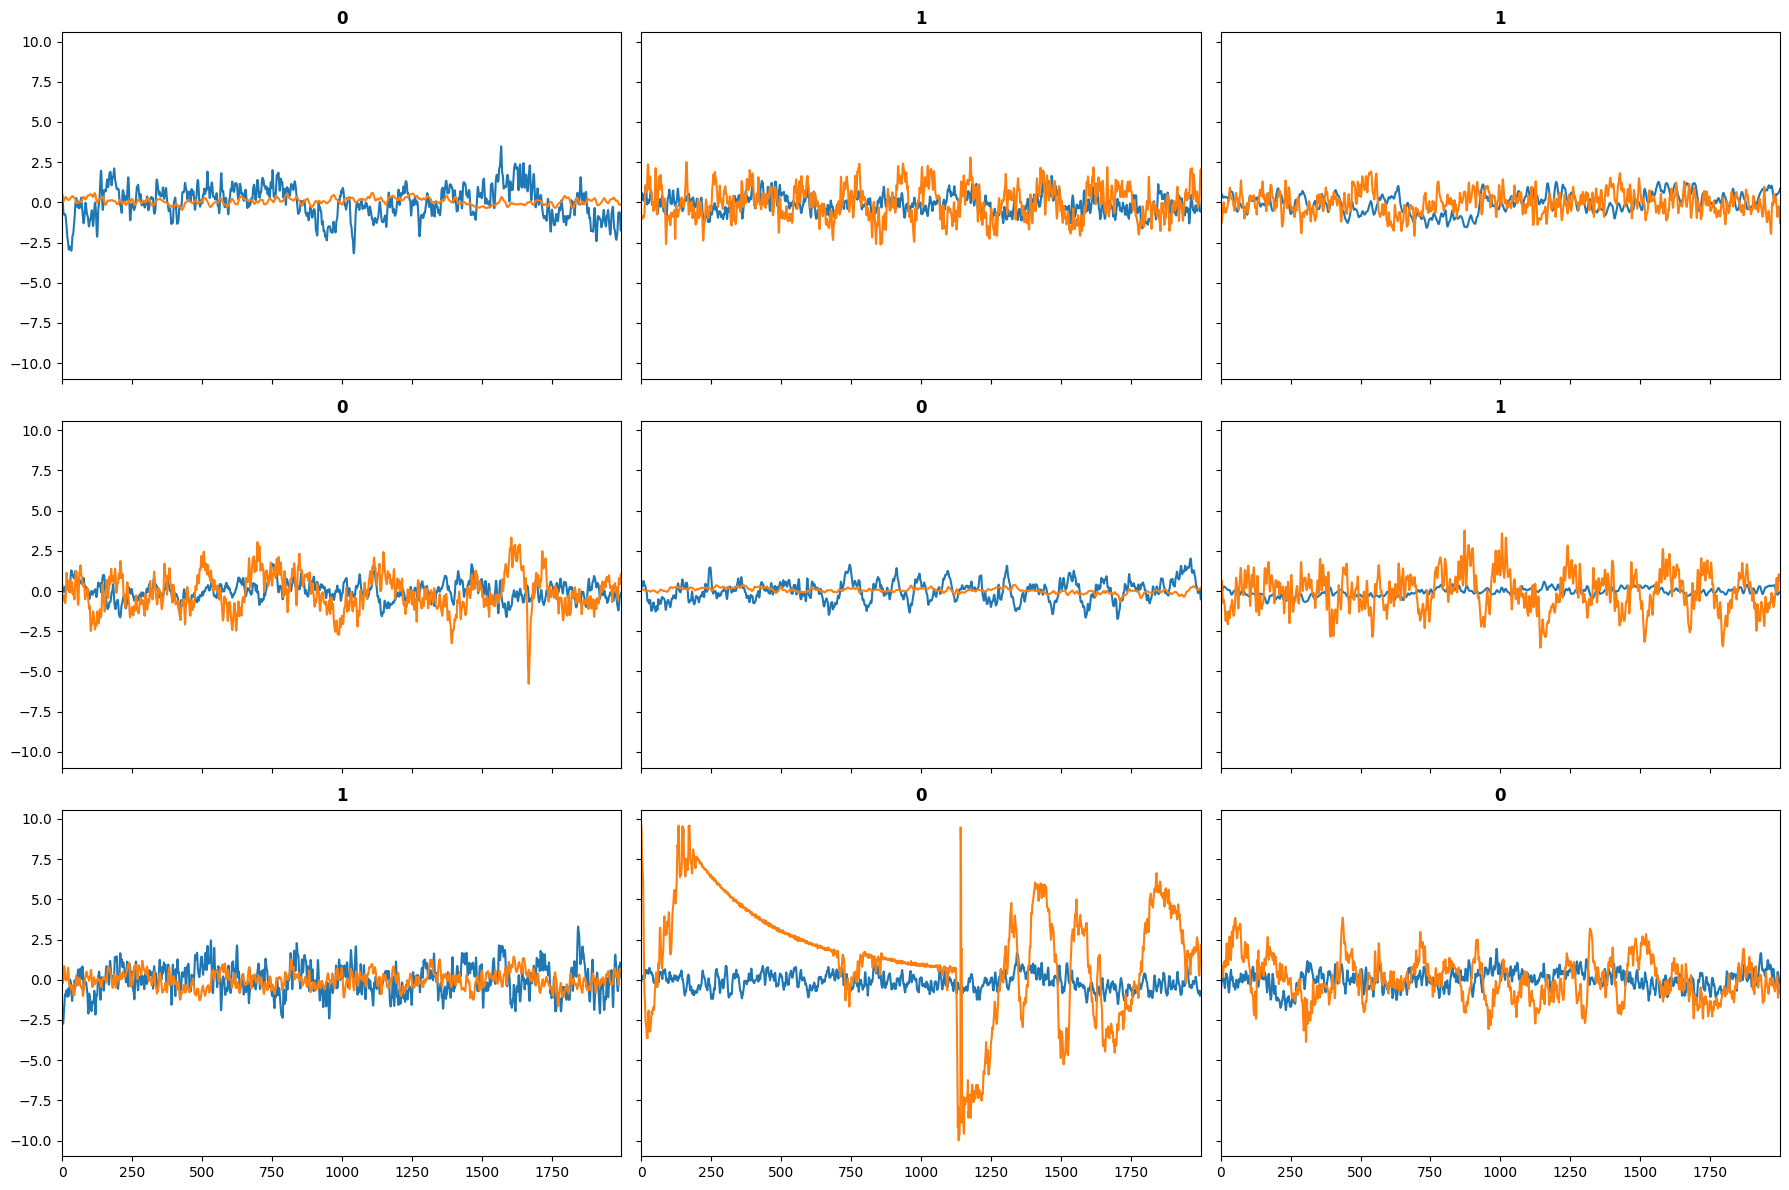

In [10]:
dls.show_batch(sharey=True)

### Build the model

In [9]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[accuracy, F1Score()])
#learn.save('stage0')

### Find optimal learning rate

In [ ]:
#learn.load('stage0')
learn.lr_find()

### Train the model

In [10]:
epochs = 1000

learn.fit_one_cycle(epochs, lr_max=1e-5)
#learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.769687,0.703261,0.500000,0.664835,00:05
1,0.767251,0.703384,0.500000,0.664835,00:02
2,0.761307,0.704152,0.500000,0.664835,00:02
3,0.760758,0.705348,0.500000,0.664835,00:02
4,0.760107,0.707013,0.500000,0.664835,00:02
5,0.761103,0.709164,0.500000,0.664835,00:02
6,0.762163,0.712127,0.500000,0.664835,00:02
7,0.760904,0.715992,0.500000,0.664835,00:02
8,0.757838,0.721124,0.500000,0.664835,00:02
9,0.758337,0.726799,0.500000,0.664835,00:02


### Plot model performance

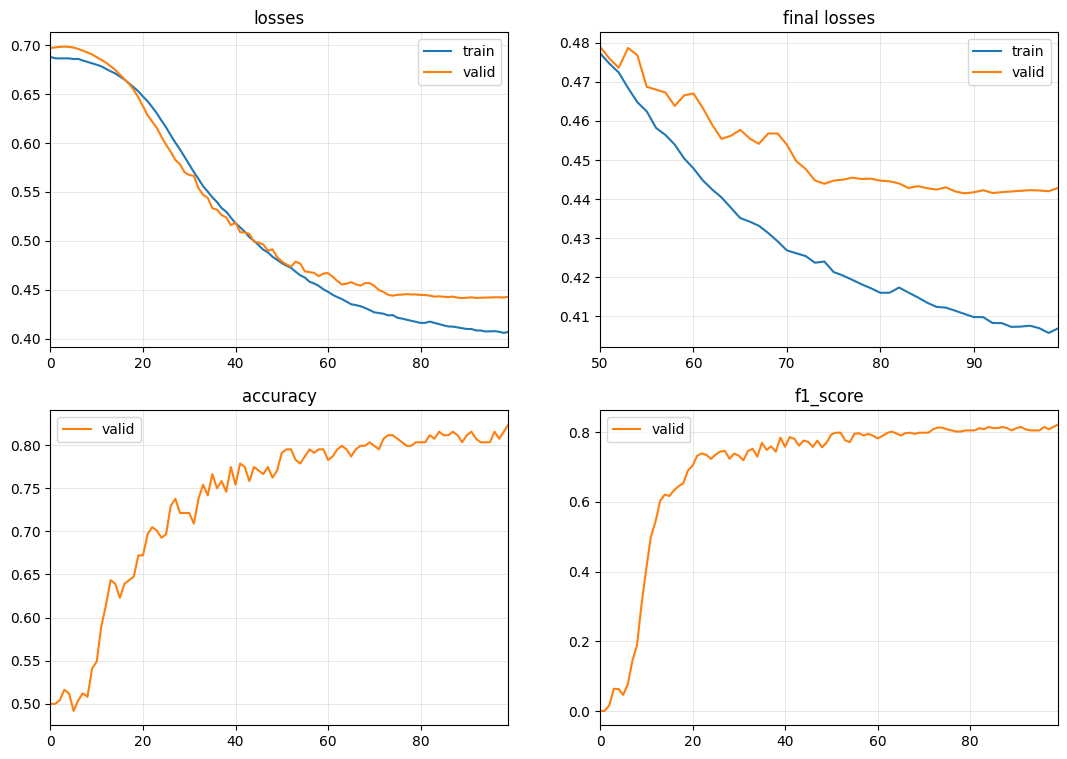

In [13]:
learn.plot_metrics()

### Visualize a batch of predictions

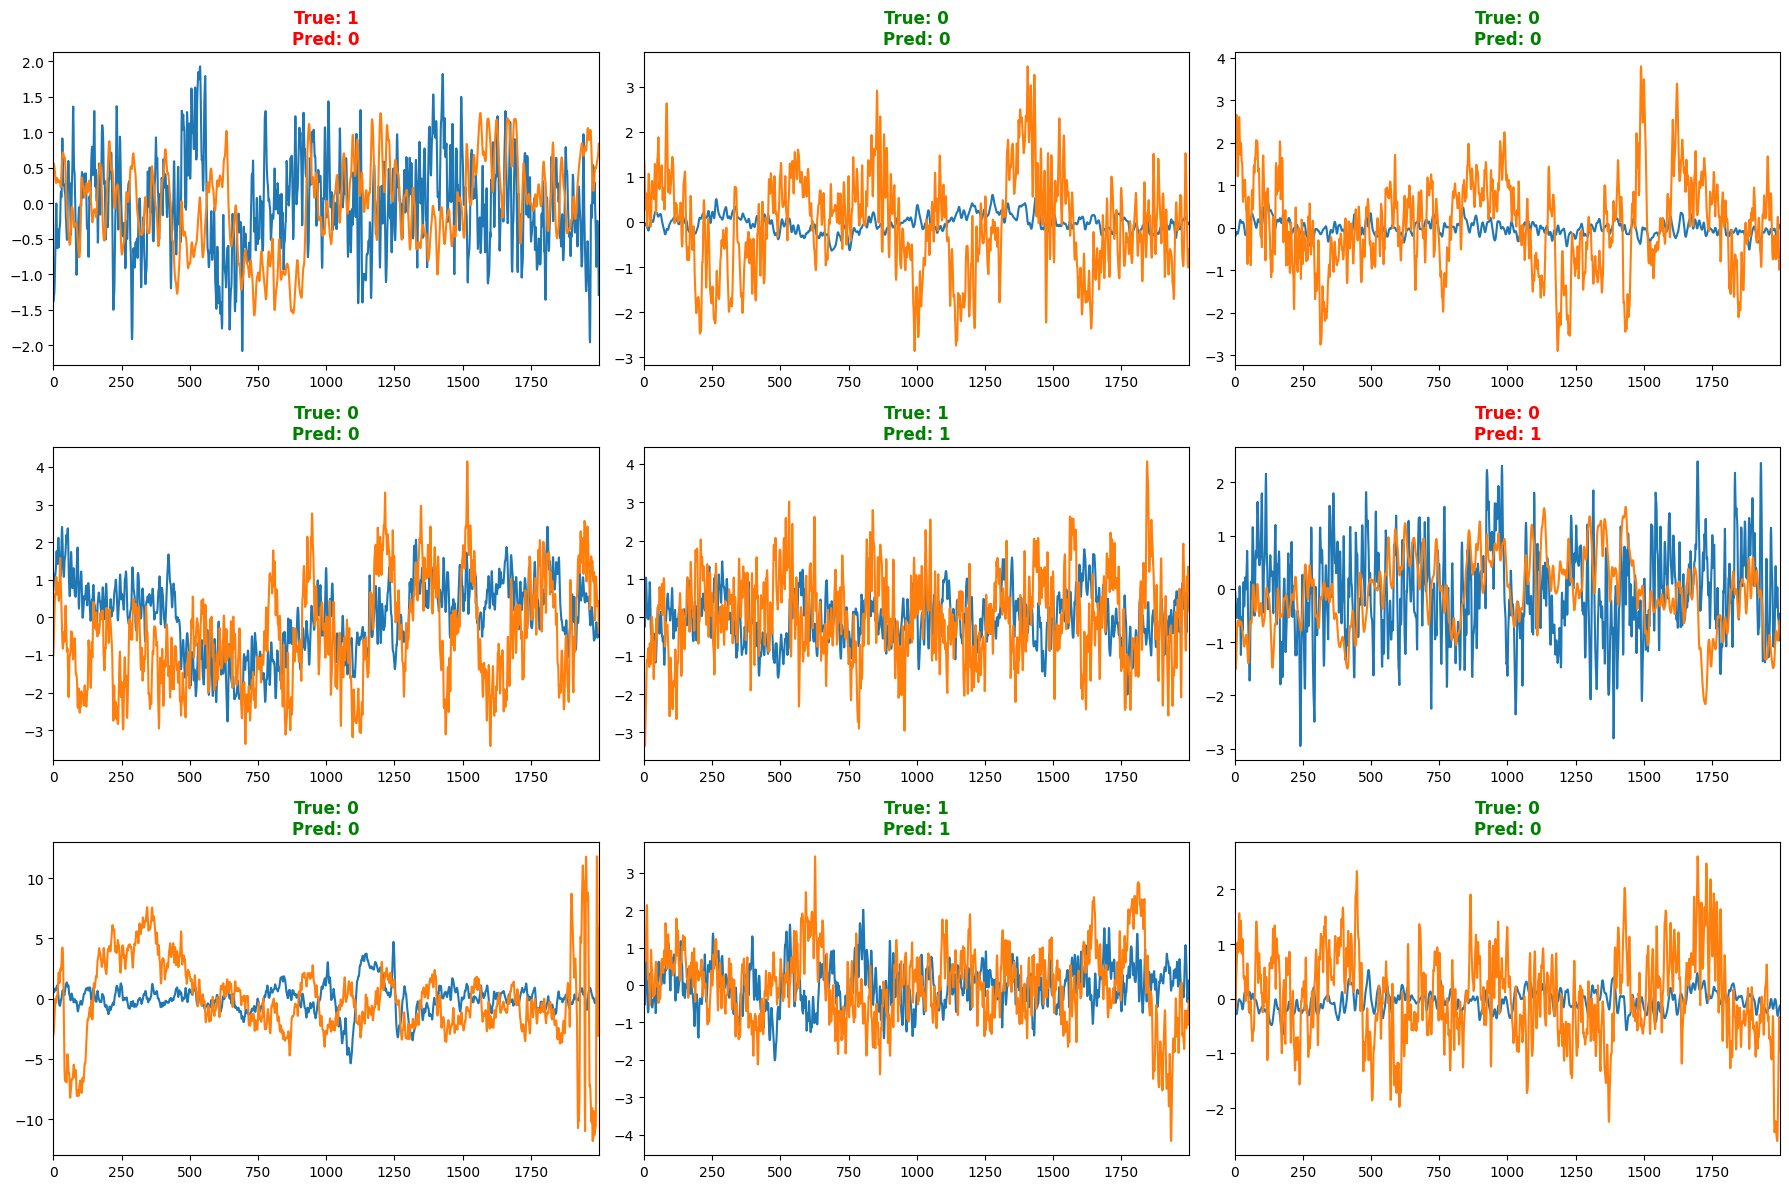

In [14]:
learn.show_results()

### Prediction probabilities

In [1]:
learn.show_probas()

NameError: name 'learn' is not defined

### Confusion matrix

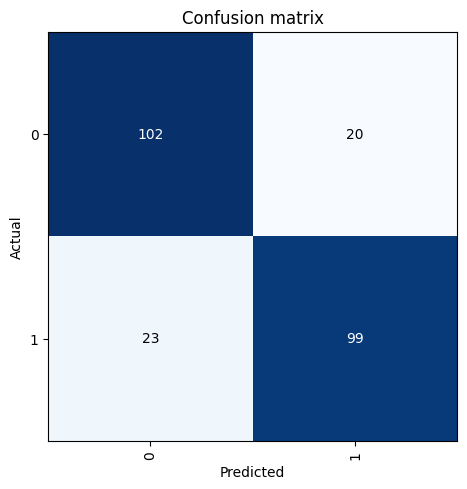

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
valid_probas, valid_targets, valid_preds

# Model evaluation on the test set

In [17]:
X_test = np.load('test_set.npy')
test_ds = dls.dataset.add_test(X_test)
test_dl = dls.valid.new(test_ds)

In [18]:
threshold = 0.5

test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas = torch.round(test_probas * 100) / 100
predictions = np.where(test_probas[:, 1] > threshold, 1, 0).astype(int)

with open("submission.csv", "w") as f:
    f.write("win_id,label\n")
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
        
print(len(predictions[predictions>0]))

142


# Create submission file using model predictions

In [37]:
learn = load_learner_all(path = 'export',
                         dls_fname='dls_balanced_best',
                         model_fname='model_balanced_best',
                         learner_fname='learner_balanced_best')

In [ ]:
epochs = 10

learn.fit_one_cycle(epochs+1, lr_max=1e-5)

In [ ]:
num_diff = 1
counter = 0
threshold = 0.5

while num_diff != 0:
    counter += 1
    epochs = 1
    with learn.no_logging():
        learn.fit_one_cycle(epochs, lr_max=1e-5)
    test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
    test_probas = torch.round(test_probas * 100) / 100
    predictions = np.where(test_probas[:, 1] > threshold, 1, 0).astype(int)
    best_submission = np.loadtxt('submission_best.csv', delimiter=',', skiprows=1, dtype=int)
    diff = predictions - best_submission[:, 1]
    num_diff = len(diff[diff != 0])
    print("Iterations:", counter, "Diffs:", num_diff)


In [53]:
learn.save_all(path='export', dls_fname='dls_balanced_best_42', model_fname='model_balanced_best_42', learner_fname='learner_balanced_best_42')

AttributeError: save